In [ ]:
!pip install pycocotools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/farelptraalbana/klasifikasi-sampah.git

Cloning into 'klasifikasi-sampah'...
remote: Enumerating objects: 888, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 888 (delta 3), reused 8 (delta 2), pack-reused 875 (from 1)
Receiving objects: 100% (888/888), 29.35 MiB | 41.45 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
%cd /content/klasifikasi-sampah

/content/klasifikasi-sampah


### **Cek Kesesuaian Anotasi Label Dataset Training dan Testing**

In [ ]:
import json
import os

def validate_coco_annotation_file(file_path):
    """
    Validasi struktur dasar file annotasi COCO
    """
    try:
        with open(file_path, 'r') as f:
            coco_data = json.load(f)

        # Cek keberadaan kunci utama
        required_keys = ['images', 'annotations', 'categories']
        for key in required_keys:
            if key not in coco_data:
                print(f"❌ Missing key: {key}")
                return False

        # Validasi images
        print(f"📸 Total Images: {len(coco_data['images'])}")

        # Validasi annotations
        print(f"🏷️ Total Annotations: {len(coco_data['annotations'])}")

        # Validasi categories
        print(f"🏷️ Total Categories: {len(coco_data['categories'])}")

        return True
    except json.JSONDecodeError:
        print("❌ Invalid JSON format")
        return False
    except Exception as e:
        print(f"❌ Error: {e}")
        return False

def compare_coco_annotation_files(train_file, test_file):
    """
    Membandingkan struktur dan kategori antara file training dan testing
    """
    with open(train_file, 'r') as f_train:
        train_data = json.load(f_train)

    with open(test_file, 'r') as f_test:
        test_data = json.load(f_test)

    # Bandingkan kategori
    train_categories = {cat['name'] for cat in train_data['categories']}
    test_categories = {cat['name'] for cat in test_data['categories']}

    print("🔍 Kategori Perbandingan:")
    print(f"Kategori Training: {train_categories}")
    print(f"Kategori Testing: {test_categories}")

    if train_categories != test_categories:
        print("❌ Kategori TIDAK KONSISTEN!")
        print("Perbedaan Kategori:")
        print("Hanya ada di Training:", train_categories - test_categories)
        print("Hanya ada di Testing:", test_categories - train_categories)
        return False

    print("✅ Kategori KONSISTEN")

    # Bandingkan struktur
    train_image_ids = {img['id'] for img in train_data['images']}
    test_image_ids = {img['id'] for img in test_data['images']}

    print(f"\n📊 Total Image ID Training: {len(train_image_ids)}")
    print(f"📊 Total Image ID Testing: {len(test_image_ids)}")

    # Cek overlap image ID
    overlap_ids = train_image_ids.intersection(test_image_ids)
    if overlap_ids:
        print(f"⚠️ Peringatan: Ada {len(overlap_ids)} Image ID yang sama di training dan testing")

    return True

def check_annotation_distribution(file_path):
    """
    Mengecek distribusi annotasi per kategori
    """
    with open(file_path, 'r') as f:
        coco_data = json.load(f)

    # Hitung distribusi annotasi
    category_counts = {}
    for annotation in coco_data['annotations']:
        category_id = annotation['category_id']
        category_name = next(cat['name'] for cat in coco_data['categories'] if cat['id'] == category_id)

        if category_name not in category_counts:
            category_counts[category_name] = 0
        category_counts[category_name] += 1

    print("📊 Distribusi Annotasi per Kategori:")
    for category, count in category_counts.items():
        print(f"{category}: {count} annotasi")

    return category_counts

def main_debug():
    train_annotation_file = "debris_dataset/train/coco_annotations_train.json"
    test_annotation_file = "debris_dataset/test/coco_annotations_test.json"

    print("=== Validasi File Training ===")
    validate_coco_annotation_file(train_annotation_file)

    print("\n=== Validasi File Testing ===")
    validate_coco_annotation_file(test_annotation_file)

    print("\n=== Perbandingan Kategori ===")
    compare_coco_annotation_files(train_annotation_file, test_annotation_file)

    print("\n=== Distribusi Annotasi Training ===")
    check_annotation_distribution(train_annotation_file)

    print("\n=== Distribusi Annotasi Testing ===")
    check_annotation_distribution(test_annotation_file)

if __name__ == "__main__":
    main_debug()

=== Validasi File Training ===
📸 Total Images: 640
🏷️ Total Annotations: 2124
🏷️ Total Categories: 4

=== Validasi File Testing ===
📸 Total Images: 160
🏷️ Total Annotations: 588
🏷️ Total Categories: 4

=== Perbandingan Kategori ===
🔍 Kategori Perbandingan:
Kategori Training: {'Kantong Plastik', 'Botol Plastik', 'Bungkus Makanan', 'Bungkus Minuman'}
Kategori Testing: {'Kantong Plastik', 'Botol Plastik', 'Bungkus Makanan', 'Bungkus Minuman'}
✅ Kategori KONSISTEN

📊 Total Image ID Training: 640
📊 Total Image ID Testing: 160
⚠️ Peringatan: Ada 160 Image ID yang sama di training dan testing

=== Distribusi Annotasi Training ===
📊 Distribusi Annotasi per Kategori:
Botol Plastik: 303 annotasi
Bungkus Minuman: 504 annotasi
Kantong Plastik: 793 annotasi
Bungkus Makanan: 524 annotasi

=== Distribusi Annotasi Testing ===
📊 Distribusi Annotasi per Kategori:
Bungkus Minuman: 126 annotasi
Kantong Plastik: 219 annotasi
Botol Plastik: 86 annotasi
Bungkus Makanan: 157 annotasi


### **Import Library Yang Diperlukan**

In [ ]:
# Imports
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import numpy as np
import pandas as pd
import cv2
import json

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import sklearn.metrics
import seaborn as sns
from tqdm import tqdm

### **Parameter Yang Dibutuhkan**

In [ ]:
# Hyperparameters
#test_set_length = 160 		 # Test set (number of images)
train_batch_size = 16  		 # Train batch size
test_batch_size = 16    		 # Test batch size
num_classes = 4        		 # Number of classes
learning_rate = 0.001  		 # Learning rate
num_epochs = 20      	     # Number of epochs
save_path = '/content/drive/MyDrive/SKRIPSI/pre-trained_model/model_20_epoch'

### **Cek Jika Dataset Merupakan Format .csv**

In [ ]:
def csv_to_coco(csv_path, json_output_path):
    """
    Mengonversi CSV annotations menjadi format COCO JSON
    """
    df = pd.read_csv(csv_path)

    images = []
    annotations = []
    categories = []

    image_id = 0
    annotation_id = 0
    category_dict = {}
    for _, row in df.iterrows():
        # Tambahkan image
        image_name = row['filename']
        if image_name not in [img['file_name'] for img in images]:
            images.append({
                "id": image_id,
                "file_name": image_name,
                "width": row['width'],
                "height": row['height']
            })
            current_image_id = image_id
            image_id += 1
        else:
            current_image_id = next(img['id'] for img in images if img['file_name'] == image_name)

        # Tambahkan categories
        class_name = row['class']
        if class_name not in category_dict:
            category_id = len(category_dict) + 1
            category_dict[class_name] = category_id
            categories.append({"id": category_id, "name": class_name})

        # Tambahkan annotations
        annotations.append({
            "id": annotation_id,
            "image_id": current_image_id,
            "bbox": [row['xmin'], row['ymin'], row['xmax'] - row['xmin'], row['ymax'] - row['ymin']],
            "category_id": category_dict[class_name],
            "area": (row['xmax'] - row['xmin']) * (row['ymax'] - row['ymin']),
            "iscrowd": 0
        })
        annotation_id += 1

    coco_output = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    with open(json_output_path, 'w') as f:
        json.dump(coco_output, f, indent=4)

### **Cek Label Apakah Sesuai atau Tidak**

In [ ]:
def create_labels_dict_from_coco(coco_json_path):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    labels_dict = {category["id"] - 1 : category["name"] for category in coco_data["categories"]}

    with open('labels.txt', 'w') as f:
        json.dump(labels_dict, f)

    return labels_dict

# Call the function to create the labels_dict
labels_dict = create_labels_dict_from_coco("debris_dataset/train/coco_annotations_train.json")  # Or your desired path

print(labels_dict)


def parse_coco_annotation(coco_json_path, image_id):
    """
    Parsing anotasi COCO untuk ID gambar tertentu

    Args:
        coco_json_path (str): Path ke file JSON COCO
        image_id (int): ID gambar yang ingin diambil annotasinya

    Returns:
        tuple: Daftar bounding boxes dan label
    """
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    boxes = []
    labels = []

    for annotation in coco_data['annotations']:
        if annotation['image_id'] == image_id:
            bbox = annotation['bbox']  # [x, y, width, height]
            xmin, ymin, width, height = bbox
            xmax = xmin + width
            ymax = ymin + height

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(annotation['category_id'])

    return boxes, labels

{0: 'Botol Plastik', 1: 'Bungkus Makanan', 2: 'Bungkus Minuman', 3: 'Kantong Plastik'}


### **Inisialisasi Kelas Coco Dataset**

In [ ]:
class CocoDataset(torch.utils.data.Dataset):
    """
    Custom Dataset untuk memuat data COCO
    """
    def __init__(self, dataset_dir, annotation_file):
        self.dataset_dir = dataset_dir
        self.coco = COCO(annotation_file)
        self.image_ids = self.coco.getImgIds()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.dataset_dir, image_info['file_name'])

        # Muat gambar
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Muat annotations
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            # Validate bounding box coordinates
            if bbox[0] < 0 or bbox[1] < 0 or bbox[0] + bbox[2] > image_info['width'] or bbox[1] + bbox[3] > image_info['height']:
                print(f"Warning: Invalid bounding box coordinates for image ID {image_id}, annotation ID {ann['id']}. Skipping this annotation.")
                continue  # Skip this annotation if it's invalid

            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            labels.append(ann['category_id'])

        # Menggeser label agar dimulai dari 0
        labels = [label - 1 for label in labels]

        # Konversi ke tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Ensure boxes and labels are not empty and labels are within the valid range
        if boxes.shape[0] == 0 or labels.shape[0] == 0 or any(label.item() < 0 or label.item() >= num_classes for label in labels):
            print(f"Warning: Invalid annotations (empty or out of range) found for image ID {image_id}. Skipping this image.")
            return None, None  # Return None to indicate an empty sample

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id]),
            "area": torch.tensor([ann['area'] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.zeros((len(anns),), dtype=torch.int64)
        }

        image = torch.from_numpy(image).float() / 255.0
        image = image.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)

        return image, target

    def __len__(self):
        return len(self.image_ids)

### **Visualisasi Dataset Yang Sesuai**

In [ ]:
def visualize_dataset_samples(dataset, labels_dict, num_samples=2):
    """
    Memvisualisasikan sampel dataset dengan bounding box dan label kelas

    Args:
        dataset (torch.utils.data.Dataset): Dataset yang akan divisualisasikan
        labels_dict (dict): Dictionary mapping label ID ke nama kelas
        num_samples (int, optional): Jumlah sampel yang akan ditampilkan. Default 10.
    """
    for i in range(min(num_samples, len(dataset))):
        image, target = dataset[i]

        # Ubah urutan dimensi untuk visualisasi
        image = image.permute(1, 2, 0)

        # Konversi ke numpy array
        image = image.numpy()
        boxes = target['boxes']
        labels = target['labels']

        fig, ax = plt.subplots(1, figsize=(10, 8))
        ax.imshow(image)

        for box, label in zip(boxes, labels):
            # Buat rectangle untuk bounding box
            rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)

            # Ambil nama kelas
            class_name = labels_dict[label.item()]

            # Cetak informasi bounding box
            print(f"Sampel {i} - Bounding box: {box}, Label: {label}, Nama Kelas: {class_name}")

            # Tambahkan teks label pada gambar
            ax.text(
                box[0],
                box[1],
                class_name,
                color='r',
                fontsize=10,
                verticalalignment='bottom'
            )

        plt.title(f'Sampel Dataset {i}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Tambahkan di dalam fungsi main() atau sebagai langkah terpisah
def verify_dataset():
    # Muat labels dictionary dari file training
    labels_dict = create_labels_dict_from_coco("debris_dataset/train/coco_annotations_train.json")

    # Buat dataset training
    dataset_train = CocoDataset(
        dataset_dir="debris_dataset/train/",
        annotation_file="debris_dataset/train/coco_annotations_train.json"
    )

    # Visualisasi sampel dataset training
    visualize_dataset_samples(dataset_train, labels_dict)

### **Fungsi Latih Model Menggunakan Pre-Trained Model**

In [ ]:
def get_model(num_classes):
    """
    Mendapatkan model Faster R-CNN yang telah dilatih sebelumnya
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

### **Fungsi Perhitungan mAP**

In [ ]:
def calculate_map(coco_gt, coco_dt, label_names):
    """
    Menghitung dan menampilkan mAP untuk setiap epoch dan setiap kelas.

    Args:
        coco_gt: Objek COCO untuk ground truth.
        coco_dt: Objek COCO untuk deteksi.
        label_names: Daftar nama label kelas.
    """
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Menampilkan mAP untuk setiap kelas dalam persentase
    precisions = coco_eval.eval['precision']
    for class_id, label_name in enumerate(label_names):
        ap = np.mean(precisions[class_id, :, :, 0, 2]) * 100  # Kalikan dengan 100 untuk persentase
        print(f"AP for {label_name}: {ap:.2f}%")  # Format output dengan tanda %

    # Mengembalikan mAP keseluruhan dalam persentase
    map_score = coco_eval.stats[0] * 100  # Kalikan dengan 100 untuk persentase
    return map_score

### **Fungsi Plot Confussion Matrix**

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, filename):
    """
    Membuat dan menyimpan matriks konfusi
    """
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Label Prediksi")
    plt.ylabel("Label Sebenarnya")
    plt.title("Matriks Konfusi")
    plt.savefig(filename)
    plt.show()

### **Main Function**

In [ ]:
def main():
    # Enable device-side assertions
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    os.environ['TORCH_USE_CUDA_DSA'] = '1'

    # Pengaturan perangkat
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Membuat dataset dengan file annotasi yang berbeda
    dataset_train = CocoDataset(
        dataset_dir="debris_dataset/train/",
        annotation_file="debris_dataset/train/coco_annotations_train.json"
    )
    dataset_test = CocoDataset(
        dataset_dir="debris_dataset/test/",
        annotation_file="debris_dataset/test/coco_annotations_test.json"
    )

    # Membuat data loader
    data_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=train_batch_size,
        shuffle=True,
        collate_fn=utils.collate_fn
    )
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=test_batch_size,
        shuffle=False,
        collate_fn=utils.collate_fn
    )

    # Pastikan label konsisten antara training dan testing
    labels_dict = create_labels_dict_from_coco("debris_dataset/train/coco_annotations_train.json")

    verify_dataset()

    # Mendapatkan model
    model = get_model(num_classes)
    model.to(device)

    # Definisikan label_names
    label_names = list(labels_dict.values())

    # Pengoptimalan
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

    # Inisialisasi untuk tracking
    all_losses = []
    map_per_epoch = []
    best_map = 0.0

    # Pelatihan
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training
        model.train()
        loss_value = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        all_losses.append(loss_value)

        # Evaluasi
        model.eval()
        all_predictions_epoch = []

        # Evaluasi menggunakan fungsi dari engine.py
        coco_evaluator, all_predictions_epoch = evaluate(
            model,
            data_loader_test,
            device=device,
            all_predictions=[],
            print_freq=10
        )

        # Hitung mAP
        coco_gt = COCO("debris_dataset/test/coco_annotations_test.json")

        if all_predictions_epoch:
            coco_dt = coco_gt.loadRes(all_predictions_epoch)

            # Hitung mAP
            map_score = calculate_map(coco_gt, coco_dt, label_names)
            map_per_epoch.append(map_score)

            # Simpan model terbaik
            if map_score > best_map:
                best_map = map_score
                torch.save(model.state_dict(), f"best_model_map_{map_score:.2f}.pth")
                print(f"Model tersimpan dengan mAP terbaik: {best_map:.2f}%")
        else:
            print("Peringatan: Tidak ada prediksi untuk menghitung mAP.")

    # Visualisasi Loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), all_losses)
    plt.title('Riwayat Loss Pelatihan')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Visualisasi mAP
    plt.subplot(1, 2, 2)
    # Ensure x and y have the same length
    x_axis = range(1, len(map_per_epoch) + 1)  # Use the length of map_per_epoch for x-axis
    plt.plot(x_axis, map_per_epoch)  # Plot using adjusted x-axis
    plt.title('mAP per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('mAP (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Simpan model akhir
    torch.save(model.state_dict(), save_path)

    # Evaluasi final dan confusion matrix
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader_test):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            predictions = model(images)

            for i in range(len(predictions)):
                predicted_labels = []
                if 'boxes' in predictions[i] and predictions[i]['boxes'].dim() > 0:
                    keep_indices = torchvision.ops.nms(
                        predictions[i]['boxes'],
                        predictions[i]['scores'],
                        iou_threshold=0.7
                    )

                    for box_idx in keep_indices:
                        if predictions[i]['scores'][box_idx].item() > 0.7:
                            label_index = predictions[i]['labels'][box_idx].item()

                            if 0 < label_index <= len(labels_dict):
                                predicted_labels.append(labels_dict[label_index])
                            else:
                                print(f"Warning: Predicted label index {label_index} is out of range, skipping.")

                target_labels = [labels_dict.get(t.item(), "Unknown") for t in targets[i]['labels']]
                all_predictions.extend(predicted_labels)
                all_targets.extend(target_labels)

    # Visualisasi Confusion Matrix
    class_labels = list(labels_dict.values())
    plot_confusion_matrix(all_targets, all_predictions, class_labels, "confusion_matrix.png")

### **Run Main Function**

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Sampel 0 - Bounding box: tensor([234.0000,  73.0000, 314.5000, 178.0000]), Label: 0, Nama Kelas: Botol Plastik
Sampel 0 - Bounding box: tensor([ 90.0000, 385.0000, 182.0000, 544.5000]), Label: 0, Nama Kelas: Botol Plastik
Sampel 0 - Bounding box: tensor([468.0000, 494.0000, 522.5000, 578.5000]), Label: 2, Nama Kelas: Bungkus Minuman


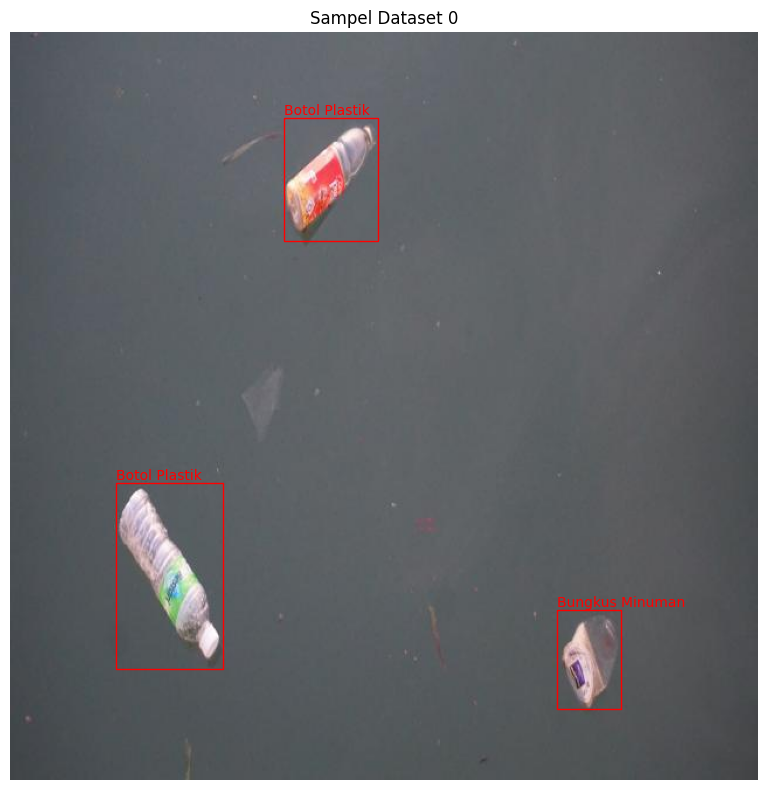

Sampel 1 - Bounding box: tensor([299.0000, 227.0000, 378.0000, 383.5000]), Label: 3, Nama Kelas: Kantong Plastik


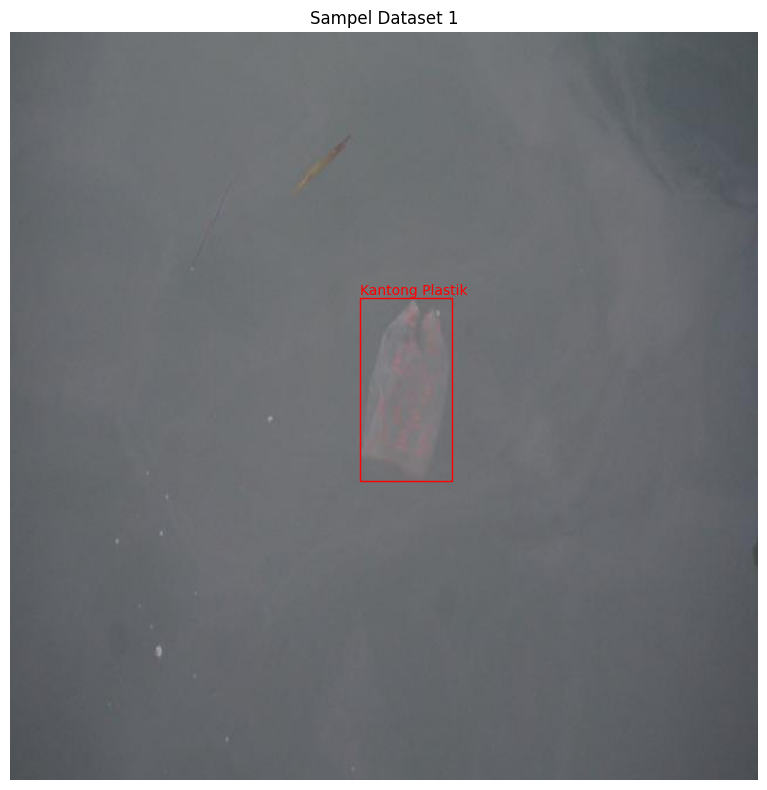

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 155MB/s]



Epoch 1/20
Training Model
Epoch: [1]  [ 0/40]  eta: 0:03:57  lr: 0.000027  loss: 1.5631 (1.5631)  loss_classifier: 1.2836 (1.2836)  loss_box_reg: 0.1805 (0.1805)  loss_objectness: 0.0831 (0.0831)  loss_rpn_box_reg: 0.0159 (0.0159)  time: 5.9301  data: 0.1586  max mem: 11366
Epoch: [1]  [10/40]  eta: 0:01:31  lr: 0.000283  loss: 1.3508 (1.3025)  loss_classifier: 1.0587 (0.9774)  loss_box_reg: 0.2022 (0.2112)  loss_objectness: 0.0831 (0.1024)  loss_rpn_box_reg: 0.0100 (0.0115)  time: 3.0516  data: 0.1879  max mem: 11520
Epoch: [1]  [20/40]  eta: 0:00:59  lr: 0.000539  loss: 0.7017 (0.9585)  loss_classifier: 0.3660 (0.6354)  loss_box_reg: 0.2121 (0.2165)  loss_objectness: 0.0659 (0.0944)  loss_rpn_box_reg: 0.0099 (0.0122)  time: 2.8127  data: 0.1940  max mem: 11520
Epoch: [1]  [30/40]  eta: 0:00:29  lr: 0.000795  loss: 0.5796 (0.8476)  loss_classifier: 0.2839 (0.5276)  loss_box_reg: 0.2368 (0.2270)  loss_objectness: 0.0315 (0.0797)  loss_rpn_box_reg: 0.0090 (0.0134)  time: 2.9321  data: 

ValueError: x and y must have same first dimension, but have shapes (20,) and (18,)

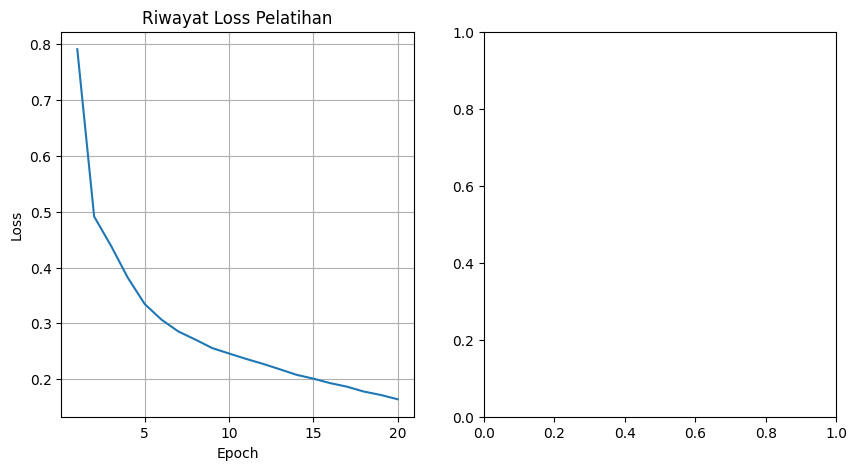

In [ ]:
if __name__ == "__main__":
    main()